In [1]:
import pandas as pd
import numpy as np

import sys
sys.path.append('../../pycore/')
from simulate import RBA_result
from utils import extract_details_from_rxnid

import matplotlib.pyplot as plt
import matplotlib.patches as mp
import matplotlib.lines as mlines
%matplotlib inline

In [2]:
df_kapp = pd.read_excel('../../parameterization/kapp/results/kapp_bydatagroup_inPerSec.xlsx')
df_kapp.index = df_kapp.id.to_list()

In [3]:
vivo_0 = pd.core.series.Series(dtype='float64')
for i in df_kapp.index:
    v = df_kapp.batch_std[i]
    if pd.isnull(v) == False:
        vivo_0[i] = v

In [4]:
df_kcat = pd.read_excel('./input/rxn_enz_kcat_kapp.xlsx')
idx = [df_kcat.rxn_id[i] + '_' + df_kcat.direction[i] for i in df_kcat.index]
df_kcat.index = idx
df = df_kcat[df_kcat['kcat_invitro (1/s)'].isnull() == False]
df = df[df.organism.str.contains('saccharomyces cerevisiae', case=False)]
idx = df.index.to_list()

vitro_0 = pd.core.series.Series(dtype='float64')
for i in idx:
    vitro_0[df_kcat.rxn_id[i] + '_' + df_kcat.direction[i]] = df_kcat.loc[i, 'kcat_invitro (1/s)']

In [5]:
df_note = pd.read_excel('./input/vivo_efficient_literature_records.xlsx')
df_note.index = df_note.Reaction.to_list()
df_note = df_note[df_note.evidence != 'None']

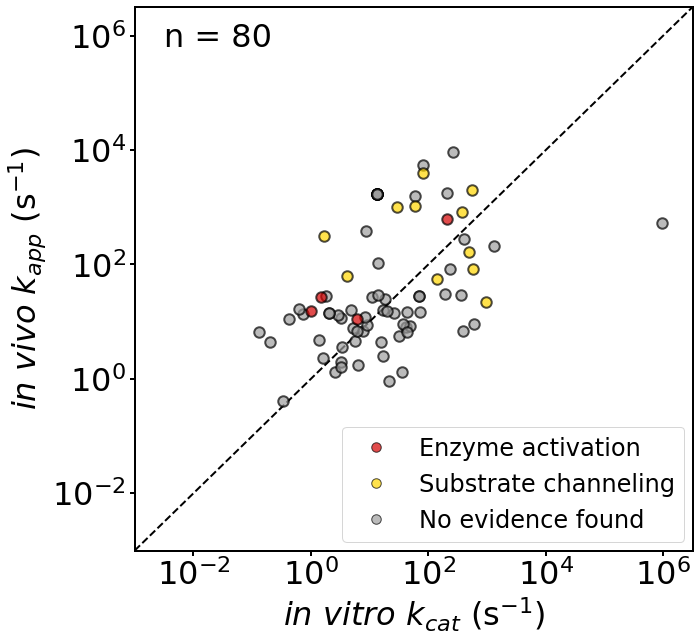

In [11]:
idx = sorted(list(set(vivo_0.index) & set(vitro_0.index)))
vivo_act = df_note[df_note.activation.isnull() == False].index.to_list()
vivo_channel = df_note[df_note.channeling.isnull() == False].index.to_list()

vivo_act = [i for i in vivo_act if i in idx]
vivo_channel = [i for i in vivo_channel if i in idx]
vivo_none = [i for i in idx if i not in vivo_act+vivo_channel]

fig,ax = plt.subplots(figsize=(10,10))
alpha = 0.7

vivos = [vivo_act, vivo_channel, vivo_none]
colors = ['#d50000', '#ffd600', '#9e9e9e']

for i in range(0, len(vivos)):
    vivo = np.log10(vivo_0[vivos[i]])
    vitro = np.log10(vitro_0[vivos[i]])
    ax.scatter(vitro, vivo, color=colors[i], edgecolor='k', alpha=alpha,
               zorder=5-i, s=110, lw=2);

lims = [-3,6.5]
ticks = [-2, 0, 2, 4, 6]
ticklabels = ['$10^{' + str(i) + '}$' for i in ticks]
ax.set_xlim(lims);
ax.set_xticks(ticks)
ax.set_xticklabels(ticklabels, fontsize=32)
ax.set_ylim(lims);
ax.set_yticks(ticks)
ax.set_yticklabels(ticklabels, fontsize=32)

w = 2
ax.xaxis.set_tick_params(width=w, length=5)
ax.yaxis.set_tick_params(width=w, length=5)
for axis in ['top','bottom','left','right']:
    ax.spines[axis].set_linewidth(w)

ax.text(-2.5, 5.8, 'n = ' + str(len(idx)), fontsize=32)

line = mlines.Line2D([-3, 7], [-3, 7], color='k', linestyle='--', zorder=0, lw=2)
ax.add_line(line);

ax.set_xlabel('$in$ $vitro$ $k_{cat}$ (s$^{-1}$)', fontsize=32);
ax.set_ylabel('$in$ $vivo$ $k_{app}$ (s$^{-1}$)', fontsize=32);

handles = [mlines.Line2D([], [], color='#d50000', lw=0, marker='o',
                         markeredgecolor='k', alpha=alpha, markersize=9.5),
           mlines.Line2D([], [], color='#ffd600', lw=0, marker='o',
                         markeredgecolor='k', alpha=alpha, markersize=9.5),
           mlines.Line2D([], [], color='#9e9e9e', lw=0, marker='o',
                         markeredgecolor='k', alpha=alpha, markersize=9.5)]
legend_labels = ['Enzyme activation', 'Substrate channeling', 'No evidence found']
ax.legend(handles, legend_labels, ncol=1, bbox_to_anchor=(0.35,0.25), fontsize=24);

#plt.savefig('../../../scRBA_figures/Fig3_kapp_vivo_vs_vitro_scatter.png', transparent=True, bbox_inches='tight')